# Examples/Tests of Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import node
import layer
import importlib
import neuralnetwork

from node import mse, mse_grad, bce, bce_grad, cce, cce_grad

from typing import List
from operator import add, mul, matmul

import torch

## Basic Check

Does it run?

In [2]:
# basic check
# expected output [[6, 8], [12, 16]]

run_basic_check = True

if run_basic_check:

    model = neuralnetwork.NeuralNetwork([(2, "id"), (2, "id")])
    test_weight = torch.Tensor([[1, 2], [3, 4]])
    test_bias = torch.Tensor([[3], [5]])
    model.params[0].weight.forward_value = test_weight
    model.params[0].bias.forward_value = test_bias
    X = torch.Tensor([[1, 1], [1, 2]]).T
    print(model.predict(X))

tensor([[ 6.,  8.],
        [12., 16.]])


## Visual Checks

Checks we can verify visually.

### Classification

In [3]:
import time

Using the cpu!
Training took 2.187851334001607 seconds on the cpu


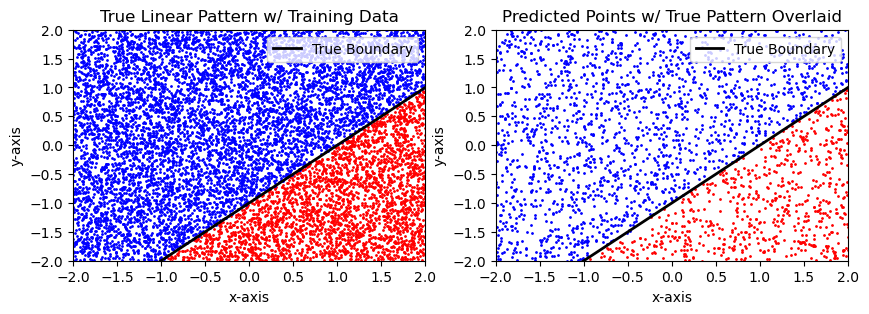

In [4]:
# test how well the neural network learns a simple linear decision boundary 
# expected output - predicted outputs should conform to the true boundary with minimal errors

training_points = 10000

draw_points = 2500

run_linear_check = True

draw = True

use_gpu = False

if use_gpu:
    if torch.cuda.is_available():
        my_device = torch.device("cuda")
        print("Using CUDA gpu!")
    elif torch.backends.mps.is_available():
        my_device = torch.device("mps")
        print("Using MPS gpu!")
else:
    my_device = torch.device("cpu")
    print("Using the cpu!")

if run_linear_check:


    X_train = np.random.rand(training_points, 2)*4 - 2
    
    true_weights = np.array([[1, -1]]).T
    true_bias = -1
    
    y_train = ((X_train @ true_weights + true_bias) > 0).squeeze()
    
    if draw:
        
        
        fig, axes = plt.subplots(1, 2, figsize = (10, 3))
        
        axes[0].set_title("True Linear Pattern w/ Training Data")
        axes[0].set_xlabel("x-axis")
        axes[0].set_ylabel("y-axis")
        axes[0].set_xlim(-2 , 2)
        axes[0].set_ylim(-2 , 2)

        X_train_red = X_train[y_train]
        X_train_blue = X_train[~y_train]


        axes[0].plot(X_train_red[ : , 0], X_train_red[ : , 1], marker = 'o', ms = 1, color = "red", ls = "")
        axes[0].plot(X_train_blue[ : , 0], X_train_blue[ : , 1], marker = 'o', ms = 1, color = "blue", ls = "")
        
        line, = axes[0].plot([-2 , 2], [-3 , 1], linewidth = 2, color = "black")
        axes[0].legend([line], ['True Boundary'], loc = 1)

    X_formatted = torch.Tensor(X_train.T).to(my_device) # formatted for training
    y_formatted = torch.Tensor(y_train.T).to(my_device).unsqueeze(dim = 0)
    
    model = neuralnetwork.NeuralNetwork([(2, "id"), (1, "sigmoid")])
    
    epochs = 100

    model.randomize_params()
    model.to_device(my_device)
    
    start_time = time.perf_counter()

    for i in range(epochs):
        
        # over each epoch, we randomly split the data into batches then train
        
        batch_size = 64
        
        shuffled = torch.randperm(training_points)
        
        X_shuffled = X_formatted[ : , shuffled]
        y_shuffled = y_formatted[ : , shuffled]
        
        
        X_partitions = torch.split(X_shuffled, batch_size, dim = 1)
        y_partitions = torch.split(y_shuffled, batch_size, dim = 1)
        
        for X_batch, y_batch in zip(X_partitions, y_partitions):
        
            model.train(X_batch, y_batch.float(), error = "bce", learning_rate = 0.1 / (i+1))
        
    end_time = time.perf_counter()
    print(f"Training took {end_time - start_time} seconds on the {my_device}")
    
    if draw:
        
        X_test = np.random. rand(draw_points, 2)*4 - 2
        
        X_test_formatted = torch.Tensor(X_test.T).to(my_device)
        y_test_pred = (model.predict(X_test_formatted) > 0.5).squeeze().cpu()
        
        X_test_red = X_test[y_test_pred.numpy()]
        X_test_blue = X_test[y_test_pred.logical_not().numpy()]


        axes[1].plot(X_test_red[ : , 0], X_test_red[ : , 1], marker = 'o', ms = 1, color = "red", ls = "")
        axes[1].plot(X_test_blue[ : , 0], X_test_blue[ : , 1], marker = 'o', ms = 1, color = "blue", ls = "")
        line,  = axes[1].plot([-2 , 2], [-3 , 1], linewidth = 2, color = "black")
        
        axes[1].set_title("Predicted Points w/ True Pattern Overlaid")
        axes[1].set_xlabel("x-axis")
        axes[1].set_ylabel("y-axis")
        axes[1].set_xlim(-2 , 2)
        axes[1].set_ylim(-2 , 2)
        axes[1].legend([line], ['True Boundary'], loc = 1)

        plt.show()

In [5]:
import matplotlib.patches as patches # use this to draw circle

Using the cpu!
Training took 76.13699029200143 seconds on the cpu


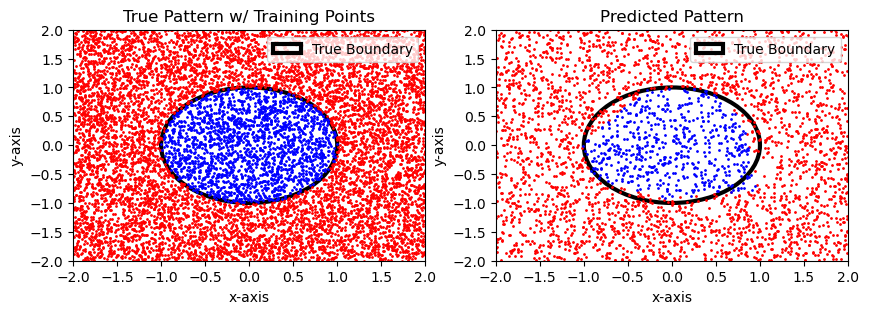

In [6]:
# learning a circular decision boundary
# expected output - predicted points should roughly match the circle.

training_points = 10000

run_circle_check = True

draw = True

use_gpu = False

if use_gpu:
    if torch.cuda.is_available():
        my_device = torch.device("cuda")
        print("Using CUDA gpu!")
    elif torch.backends.mps.is_available():
        my_device = torch.device("mps")
        print("Using MPS gpu!")
else:
    my_device = torch.device("cpu")
    print("Using the cpu!")

if run_circle_check:
    
    X_train = np.random.rand(training_points, 2) * 4 - 2
    y_train_true = np.power(X_train, 2).sum(axis = 1) > 1
    
    X_train_formatted = torch.Tensor(X_train.T).to(my_device)
    y_train_formatted = torch.Tensor(y_train_true.T).to(my_device).unsqueeze(dim = 0)
 
    if draw:
        
        draw_points = 3333
        
        fig, axes = plt.subplots(1, 2, figsize = (10, 3))

        circle = patches.Circle((0,0), 1.0, edgecolor = "black", fill = False, linewidth = 3, alpha = 1)
        
        axes[0].set_title("True Pattern w/ Training Points")
        axes[0].set_xlabel("x-axis")
        axes[0].set_ylabel("y-axis")
        axes[0].set_xlim(-2 , 2)
        axes[0].set_ylim(-2 , 2)
        
        X_train_plotting = X_train.copy()
        y_train_plotting = y_train_true.copy()
        
        X_train_red = X_train_plotting[y_train_plotting]
        X_train_blue = X_train_plotting[~y_train_plotting]
        
            
        axes[0].plot(X_train_red[ : , 0], X_train_red[ : , 1], marker = 'o', ms = 1, color = "red", ls = "")
        
        axes[0].plot(X_train_blue[ : , 0], X_train_blue[ : , 1], marker = 'o', ms = 1, color = "blue", ls = "")
    
        axes[0].add_patch(circle)
        
        axes[0].legend([circle], ['True Boundary'], loc = 1)

    model = neuralnetwork.NeuralNetwork([(2, "id"), 
                                         (4, "relu"), 
                                         (1, "sigmoid")])
    model.randomize_params()
    model.to_device(my_device)
    
    epochs = 1000
    
    start_time = time.perf_counter()

    for i in range(epochs):
        
        # over each epoch, we randomly split the data into batches then train
        
        batch_size = 32
        
        shuffled = torch.randperm(training_points)
        
        X_shuffled = X_train_formatted[ : , shuffled]
        y_shuffled = y_train_formatted[ : , shuffled]
        
        
        X_partitions = torch.split(X_shuffled, batch_size, dim = 1)
        y_partitions = torch.split(y_shuffled, batch_size, dim = 1)
        
        for X_batch, y_batch in zip(X_partitions, y_partitions):
        
            model.train(X_batch, y_batch.float(), error = "bce", learning_rate = 0.1 / (i+1))
        
    end_time = time.perf_counter()
    print(f"Training took {end_time - start_time} seconds on the {my_device}")
    
    circle = patches.Circle((0,0), 1.0, edgecolor = "black", fill = False, linewidth = 3)

    if draw:
        
        X_test = np.random.rand(draw_points, 2) * 4 - 2
        X_test_formatted = torch.Tensor(X_test).to(my_device).T
        
        y_test_pred = model.predict(X_test_formatted) > 0.5
        y_test_pred = np.array([i.item() for i in y_test_pred.cpu().squeeze()])
        
        axes[1].set_title("Predicted Pattern")
        axes[1].set_xlabel("x-axis")
        axes[1].set_ylabel("y-axis")
        axes[1].set_xlim(-2 , 2)
        axes[1].set_ylim(-2 , 2)
                
        X_test_red = X_test[y_test_pred]
        X_test_blue = X_test[~y_test_pred]
              
        axes[1].plot(X_test_red[ : , 0], X_test_red[ : , 1], marker = 'o', ms = 1, color = "red", ls = "")
        axes[1].plot(X_test_blue[ : , 0], X_test_blue[ : , 1], marker = 'o', ms = 1, color = "blue", ls = "")
        axes[1].add_patch(circle)
        
        axes[1].legend([circle], ['True Boundary'], loc = 1)
        
        plt.show()


### Regression

Using the cpu!
Training took 20.41950608299885 seconds on the cpu
The MSE is 0.002242955916402164


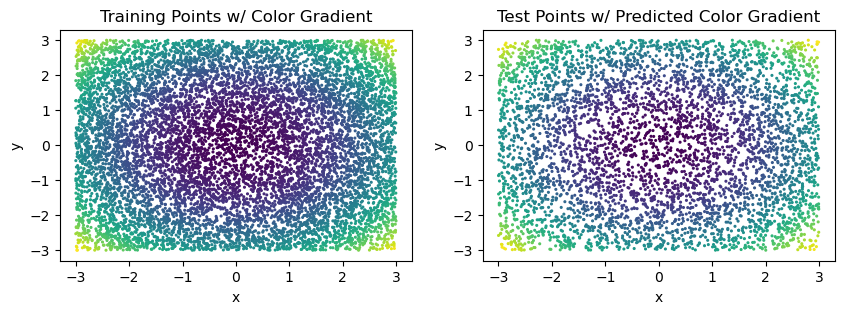

In [7]:
# test how well the network learns the norm function
# predicted color gradient of test points should look similar to that of training points

training_points = 10000

draw_points = 5000

run_regression_check = True

draw = True

use_gpu = False

if use_gpu:
    if torch.cuda.is_available():
        my_device = torch.device("cuda")
        print("Using CUDA gpu!")
    elif torch.backends.mps.is_available():
        my_device = torch.device("mps")
        print("Using MPS gpu!")
else:
    my_device = torch.device("cpu")
    print("Using the cpu!")

if run_regression_check:


    X_train = np.random.rand(training_points, 2) * 6 - 3    
    y_train = np.power(X_train, 2).sum(axis = 1)
    
    X_train_formatted = torch.Tensor(X_train.T).to(my_device)
    y_train_formatted = torch.Tensor(y_train).unsqueeze(dim = 0).to(my_device)
    
    if draw:
        
        fix, axes = plt.subplots(1, 2, figsize = (10, 3))
        axes[0].scatter(X_train[ : , 0], X_train[ : , 1], cmap = "viridis", c = y_train, s = 1.5)
        axes[0].set_title("Training Points w/ Color Gradient")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("y")
        
    architecture = [
        (2, "id"),
        (10, "tanh"),
        (10, "tanh"),
        (1, "id")
    ]
    
    model = neuralnetwork.NeuralNetwork(architecture)
    model.randomize_params()
    model.to_device(my_device)
    
    epochs = 200
    batch_size = 32
    
    start_time = time.perf_counter()
    
    for i in range(epochs):
        
        
        shuffled = torch.randperm(training_points)
        
        X_shuffled = X_train_formatted[ : , shuffled]
        y_shuffled = y_train_formatted[ : , shuffled]
    
    
        X_partitions = torch.split(X_shuffled, batch_size, dim = 1)
        y_partitions = torch.split(y_shuffled, batch_size, dim = 1)
        
        
        for X_batch, y_batch in zip(X_partitions, y_partitions):
            
            model.train(X_batch, y_batch, error = "mse", learning_rate = 0.1 / (i + 1))
    
    end_time = time.perf_counter()
    
    print(f"Training took {end_time - start_time} seconds on the {my_device}")
    
    if draw:
        
        X_draw = np.random.rand(draw_points, 2) * 6 - 3
        X_draw_formatted = torch.Tensor(X_draw.T).to(my_device)
        
        y_draw = np.power(X_draw, 2).sum(axis = 1)
        y_draw_pred = model.predict(X_draw_formatted).cpu().squeeze()
        y_draw_pred = np.array([i.item() for i in y_draw_pred])
        
        axes[1].scatter(X_draw[ : , 0], X_draw[ : , 1], cmap = "viridis", c = y_draw_pred, s = 1.5)
        axes[1].set_title("Test Points w/ Predicted Color Gradient")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")
        
        print(f"The MSE is {np.power((y_draw - y_draw_pred), 2).mean()}")
        